In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 회귀 모델 & 검증용
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.font_manager as fm
font_name = fm.FontProperties(fname='C:/Windows/Fonts/malgun.ttf').get_name()
plt.rc('font', family=font_name)


In [15]:
# 1) 데이터 불러오기
df = pd.read_csv('Processed_COVID_Data_Filled.csv', encoding = 'ANSI')

# Date 컬럼이 문자열이라면 datetime 형태로 변환
df['Date']

# 2) 데이터 샘플 확인
print(df.head())
print(df.info())
print(df.describe())


         Date  Cases       SO2        CO        O3       NO2       PM10  \
0  2020-02-01      0  0.003274  0.699089  0.026038  0.022698  63.185218   
1  2020-02-02      0  0.003502  0.748826  0.028493  0.020737  69.092334   
2  2020-02-03      0  0.003140  0.463362  0.029590  0.015894  32.560316   
3  2020-02-04      3  0.003329  0.465114  0.023674  0.019638  29.410079   
4  2020-02-05      3  0.003002  0.374520  0.029291  0.011450  22.960480   

        PM25  평균기온(℃)  평균최고기온(℃)  ...  최저기온(℃)  평균일강수량(mm)  최다일강수량(mm)  \
0  47.416719      2.2        7.8  ...     -6.8         0.0         0.2   
1  52.897434      2.1        7.8  ...    -11.2         0.0         0.7   
2  21.600817      1.3        5.7  ...     -9.7         0.0         0.7   
3  18.842018      0.1        6.3  ...    -18.6         0.3         2.0   
4  11.594881     -3.6        1.0  ...    -18.9         0.0        26.0   

   평균풍속(m/s)  최대풍속(m/s)  최대순간풍속(m/s)  평균습도(%rh)  최저습도(%rh)  일조합(hr)  \
0        1.5       12.5         1

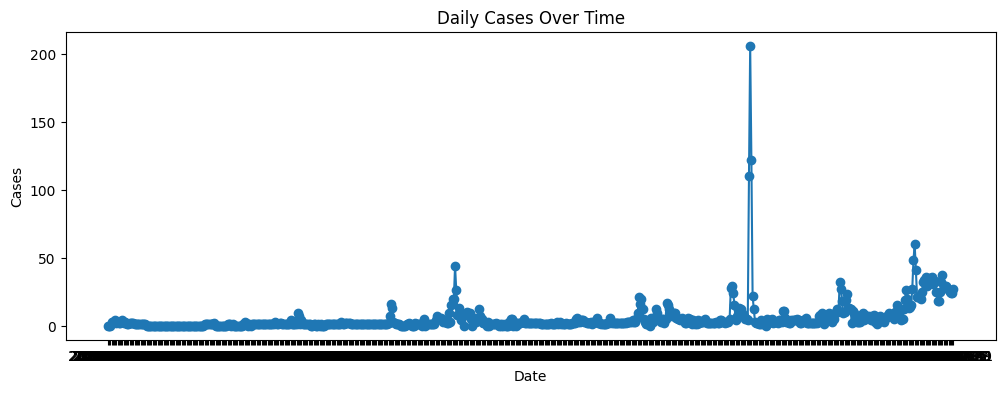

In [17]:
plt.figure(figsize=(12,4))
plt.plot(df['Date'], df['Cases'], marker='o', linestyle='-')
plt.title('Daily Cases Over Time')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.show()


C:\Users\user\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from current font.
  fig.canvas.draw()
C:\Users\user\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from current font.
  fig.canvas.draw()
C:\Users\user\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.draw()
C:\Users\user\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 50728 (\N{HANGUL SYLLABLE ON}) missing from current font.
  fig.canvas.draw()
C:\Users\user\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 49845 (\N{HANGUL SYLLABLE SEUB}) missing from current font.
  fig.canvas.draw()
C:\Users\user\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  fig.canvas.draw()
C:\Users\user\anaconda3\Lib\site

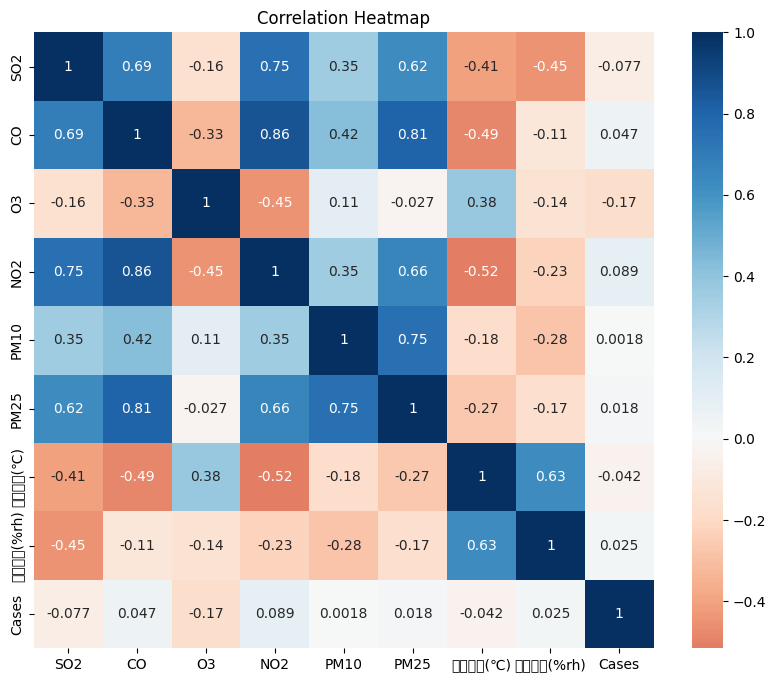

In [19]:
# 필요하다면 Date, Cases 등 제외하고 상관분석
corr_cols = ['SO2','CO','O3','NO2','PM10','PM25','평균기온(℃)','평균습도(%rh)','Cases']
corr_df = df[corr_cols].copy()

plt.figure(figsize=(10,8))
sns.heatmap(corr_df.corr(), annot=True, cmap='RdBu', center=0)
plt.title('Correlation Heatmap')
plt.show()


In [21]:
# Lag 1일, Lag 7일
df['Cases_lag1'] = df['Cases'].shift(1)
df['Cases_lag7'] = df['Cases'].shift(7)

# Lag를 추가하면 첫 며칠(1~7행)은 결측 발생 -> 제거
df = df.dropna().reset_index(drop=True)


In [25]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

In [27]:
train_cutoff = pd.to_datetime('2020-12-01')

train_df = df[df['Date'] < train_cutoff].copy()
test_df = df[df['Date'] >= train_cutoff].copy()

print("Train 데이터:", train_df.shape)
print("Test  데이터:", test_df.shape)


Train 데이터: (297, 24)
Test  데이터: (396, 24)


In [56]:
# 사용할 컬럼들 (회귀용 특징)
features = [
    'SO2','CO','O3','NO2','PM10','PM25',
    '평균기온(℃)','평균습도(%rh)',
    # 필요시 더 추가
    'Cases_lag1','Cases_lag7'
]

X_train = train_df[features]
y_train = train_df['Cases']

X_test  = test_df[features]
y_test  = test_df['Cases']

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(290, 10) (290,)
(396, 10) (396,)


In [58]:
rf = RandomForestRegressor(
    n_estimators=100, 
    max_depth=5,
    random_state=42
)
rf.fit(X_train, y_train)

# 예측
y_pred = rf.predict(X_test)

# 평가
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)  # squared=False -> RMSE
r2 = r2_score(y_test, y_pred)

print("MAE :", mae)
print("RMSE:", rmse)
print("R^2 :", r2)


MAE : 4.009510397275006
RMSE: 12.906150465066574
R^2 : 0.2987696912930423


C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


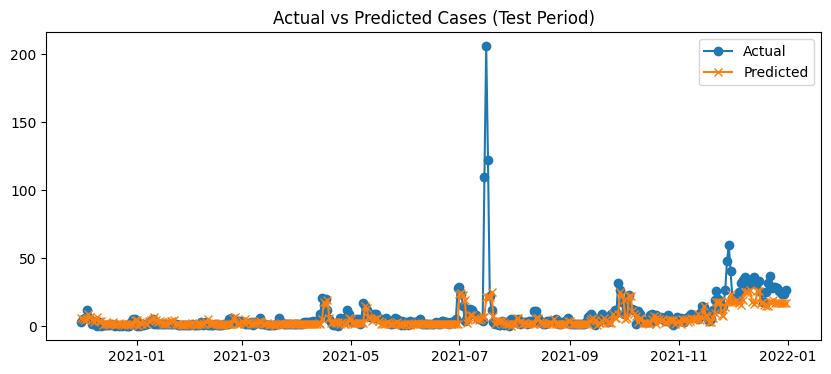

In [60]:
test_df['Pred'] = y_pred  # 예측 결과를 test_df에 붙이기

plt.figure(figsize=(10,4))
plt.plot(test_df['Date'], test_df['Cases'], label='Actual', marker='o')
plt.plot(test_df['Date'], test_df['Pred'], label='Predicted', marker='x')
plt.legend()
plt.title("Actual vs Predicted Cases (Test Period)")
plt.show()


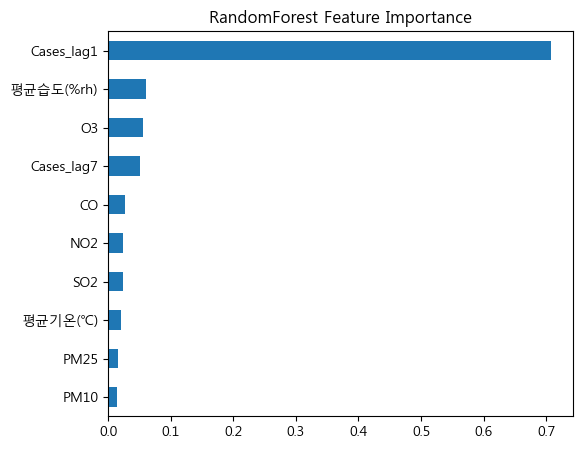

In [68]:
importances = pd.Series(rf.feature_importances_, index=features).sort_values()
plt.figure(figsize=(6,5))
importances.plot(kind='barh')
plt.title("RandomForest Feature Importance")
plt.show()


In [76]:
# permutation 피처 importance
from sklearn.inspection import permutation_importance
f_imp_v = permutation_importance(rf, X_train, y_train, n_repeats = 10, random_state=42)
f_imp_v

{'importances_mean': array([0.0159465 , 0.02072289, 0.06612263, 0.01932379, 0.01312282,
        0.01132555, 0.01474338, 0.08084213, 1.42284382, 0.04319354]),
 'importances_std': array([0.00238748, 0.00277865, 0.01110305, 0.00132686, 0.00225946,
        0.00136125, 0.00526949, 0.03500427, 0.05423201, 0.00599115]),
 'importances': array([[0.0136031 , 0.01475978, 0.02038883, 0.01835257, 0.01193443,
         0.01617099, 0.01748139, 0.01387342, 0.01724686, 0.0156536 ],
        [0.01794412, 0.01794467, 0.02563362, 0.02036405, 0.02183275,
         0.02265848, 0.02103006, 0.02393902, 0.01612016, 0.01976195],
        [0.05003611, 0.07751717, 0.06432214, 0.05461088, 0.08199854,
         0.07169229, 0.06366632, 0.04966195, 0.07764211, 0.07007881],
        [0.02072464, 0.01770333, 0.01898479, 0.01969898, 0.01824124,
         0.01917082, 0.02206511, 0.01855908, 0.01775826, 0.02033163],
        [0.01319476, 0.01534997, 0.01287016, 0.01560588, 0.01398596,
         0.01056712, 0.01488732, 0.01047733, 

In [64]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

param_grid = {
    'n_estimators': [50,100],
    'max_depth': [3,5,7],
    'min_samples_leaf':[1,3,5]
}

tscv = TimeSeriesSplit(n_splits=3)  # 예: 3등분

gsearch = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=tscv,
    n_jobs=-1
)

gsearch.fit(X_train, y_train)
print("Best params:", gsearch.best_params_)
print("Best score:", gsearch.best_score_)

best_model = gsearch.best_estimator_
y_pred_best = best_model.predict(X_test)

mae_best = mean_absolute_error(y_test, y_pred_best)
print("MAE with Best Model:", mae_best)


Best params: {'max_depth': 3, 'min_samples_leaf': 1, 'n_estimators': 50}
Best score: -1.7110338175237303
MAE with Best Model: 3.882750672357737


In [78]:
best_model.score(X_train, y_train)

0.8256478385884145

In [82]:
best_model.score(X_test,y_test)

0.2928373295563611

In [146]:
import pandas as pd
import numpy as np

# 1) 이미 df에 다음 컬럼이 있다고 가정: [Date, Cases, SO2, CO, ...]
#    Date가 datetime 타입이어야 합니다.
df = df.sort_values('Date').reset_index(drop=True)  # 시간순 정렬

# 2) 모델에 투입할 '타겟' 시계열: Cases
#    ARIMAX/SARIMAX에서는 y=타겟, exog=독립변수(다차원 가능)
y = df['Cases']

# 3) exogenous(외생 변수) : 예시로 SO2, CO, O3 등
ex_cols = ['SO2','CO','O3','NO2','PM10','PM25','평균기온(℃)','평균습도(%rh)','Cases_lag1', 'Cases_lag7']  # 가정
X = df[ex_cols]


In [377]:
ex_cols = ['SO2','CO','O3','NO2','PM10','PM25','평균기온(℃)','평균습도(%rh)', 'Cases_lag7']  # 독립변수 조정.
X = df[ex_cols]

In [379]:
train_cutoff = pd.to_datetime('2021-05-01') ## 날짜 조정.
train_mask = df['Date'] < train_cutoff

y_train = y[train_mask]
y_test  = y[~train_mask]

X_train = X[train_mask]
X_test  = X[~train_mask]


In [381]:
import statsmodels.api as sm

# SARIMAX(ARIMA) 모수 (p, d, q) or (p,d,q)(P,D,Q,S)를 임의로 지정 (단순 예)
# 실제로는 AIC/BIC, pmdarima 오토튜닝 등을 통해 찾는 것이 일반적
order = (1, 0, 1)  # p=1, d=1, q=1
seasonal_order = (0, 0, 0, 0)  # 비계절성(arima)이라면 seasonal_order=(0,0,0,0)

model = sm.tsa.statespace.SARIMAX(
    endog=y_train,
    exog=X_train,           # 외생변수
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit(disp=False)
print(results.summary())


                               SARIMAX Results                                
Dep. Variable:                  Cases   No. Observations:                  441
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -1020.130
Date:                Thu, 23 Jan 2025   AIC                           2064.261
Time:                        17:31:59   BIC                           2113.275
Sample:                             0   HQIC                          2083.598
                                - 441                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
SO2         -801.8097    955.477     -0.839      0.401   -2674.509    1070.890
CO            -0.5612      7.956     -0.071      0.944     -16.154      15.032
O3            12.9271     43.554      0.297      0.7

C:\Users\user\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [383]:
# 1) 예측 길이: len(y_test) 만큼 예측
n_test = len(y_test)

pred = results.predict(
    start=len(y_train),  # 혹은 y_train.index[-1]+1
    end=len(y_train)+n_test-1,
    exog=X_test
)

# pred는 pandas Series 형태로 반환됩니다


In [385]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = pred
y_true = y_test

mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)
print("MAE :", mae)
print("RMSE:", rmse)


MAE : 11.274680221560976
RMSE: 22.36089868683258


C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


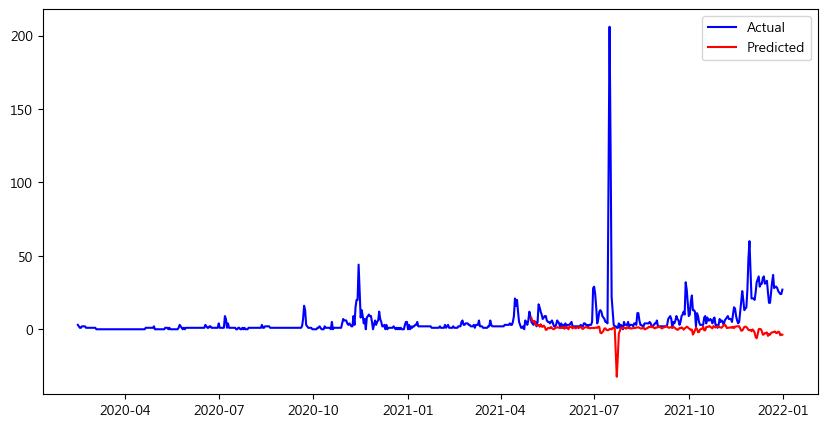

In [387]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(df['Date'], df['Cases'], label='Actual', color='blue')
# 테스트 구간의 예측선만 그려보자
plt.plot(df['Date'][~train_mask], y_pred, label='Predicted', color='red')
plt.legend()
plt.show()


In [300]:
import numpy as np

def create_sequence_features(data_array, target_array, window_size=7):
    """
    data_array: shape (N, num_features)
    target_array: shape (N,)
    window_size: 과거 n일
    return:
       X_seq: shape (N - window_size, window_size, num_features)
       y_seq: shape (N - window_size,)
    """
    Xs, ys = [], []
    for i in range(len(data_array) - window_size):
        Xs.append(data_array[i:(i+window_size)])
        ys.append(target_array[i+window_size])
    return np.array(Xs), np.array(ys)


In [239]:
# 타겟: Cases
y_arr = df['Cases'].values  # shape (N,)

# 외생변수 + 혹은 타겟(Lag)도 같이
X_arr = df[['SO2','CO','O3','NO2','PM10','PM25','평균기온(℃)','평균습도(%rh)','Cases_lag1', 'Cases_lag7']].values  # shape (N, num_features)

window_size = 7
X_seq, y_seq = create_sequence_features(X_arr, y_arr, window_size=window_size)

print("X_seq shape:", X_seq.shape)  # (N-7, 7, num_features)
print("y_seq shape:", y_seq.shape)  # (N-7,)


X_seq shape: (679, 7, 10)
y_seq shape: (679,)


In [240]:
# df.shape = N
# X_seq.shape = (N - 7, 7, num_features)
# df의 마지막 row 인덱스 = N-1
# X_seq의 마지막 샘플 인덱스 = (N-7) - 1 = N-8

# 데이터 개수
N = len(df)
train_cutoff = pd.to_datetime('2021-10-01')
cut_idx = df.index[df['Date'] >= train_cutoff][0]  # 12월1일 이후가 시작되는 인덱스

# 실제로는 window_size 고려해서 cut_idx - window_size 정도로 잘라야 할 수 있음
X_train = X_seq[: (cut_idx - window_size)]
y_train = y_seq[: (cut_idx - window_size)]

X_test  = X_seq[(cut_idx - window_size):]  # 예시
y_test  = y_seq[(cut_idx - window_size):]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(587, 7, 10) (587,)
(92, 7, 10) (92,)


In [241]:
import tensorflow as tf
from tensorflow import keras

model = keras.Sequential([
    # 입력 shape = (window_size, num_features)
    keras.layers.LSTM(32, activation='tanh', return_sequences=False, input_shape=(window_size, X_train.shape[2])),
    keras.layers.Dense(1)  # 타겟이 1차원
])

model.compile(optimizer='adam', loss='mse')
model.summary()

# 훈련
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=16,
    verbose=2
)


C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_36 (LSTM)                  │ (None, 32)             │         5,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,537 (21.63 KB)

 Trainable params: 5,537 (21.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
30/30 - 3s - 115ms/step - loss: 16.7075 - val_loss: 631.2094
Epoch 2/20
30/30 - 0s - 7ms/step - loss: 15.3691 - val_loss: 626.2626
Epoch 3/20
30/30 - 0s - 10ms/step - loss: 14.6884 - val_loss: 623.3549
Epoch 4/20
30/30 - 0s - 7ms/step - loss: 14.1782 - val_loss: 620.9962
Epoch 5/20
30/30 - 0s - 6ms/step - loss: 13.2946 - val_loss: 611.9396
Epoch 6/20
30/30 - 0s - 11ms/step - loss: 12.2891 - val_loss: 608.8323
Epoch 7/20
30/30 - 0s - 7ms/step - loss: 11.7730 - val_loss: 607.8404
Epoch 8/20
30/30 - 0s - 13ms/step - loss: 11.2727 - val_loss: 609.4846
Epoch 9/20
30/30 - 0s - 8ms/step - loss: 10.9486 - val_loss: 607.6076
Epoch 10/20
30/30 - 0s - 12ms/step - loss: 10.5723 - val_loss: 603.6758
Epoch 11/20
30/30 - 0s - 8ms/step - loss: 10.3921 - val_loss: 603.3439
Epoch 12/20
30/30 - 0s - 8ms/step - loss: 10.2023 - val_loss: 605.4509
Epoch 13/20
30/30 - 0s - 8ms/step - loss: 9.9326 - val_loss: 602.5036
Epoch 14/20
30/30 - 0s - 10ms/step - loss: 9.7057 - val_loss: 599.4662
Epoch 15/2

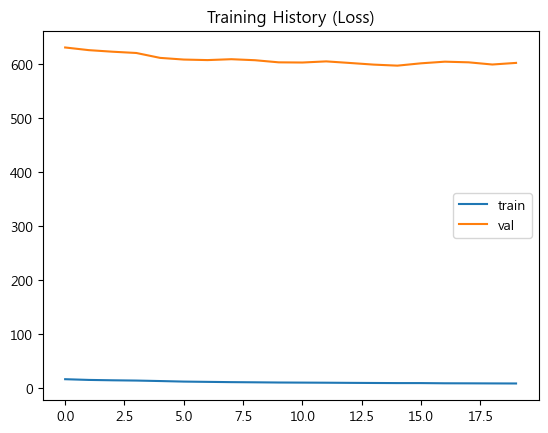

In [242]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Training History (Loss)')
plt.legend()
plt.show()


In [243]:
y_pred = model.predict(X_test).flatten()  # shape (m,)
y_true = y_test  # shape (m,)

from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)

print("MAE :", mae)
print("RMSE:", rmse)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
MAE : 11.253566050011178
RMSE: 15.532482182195135


C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


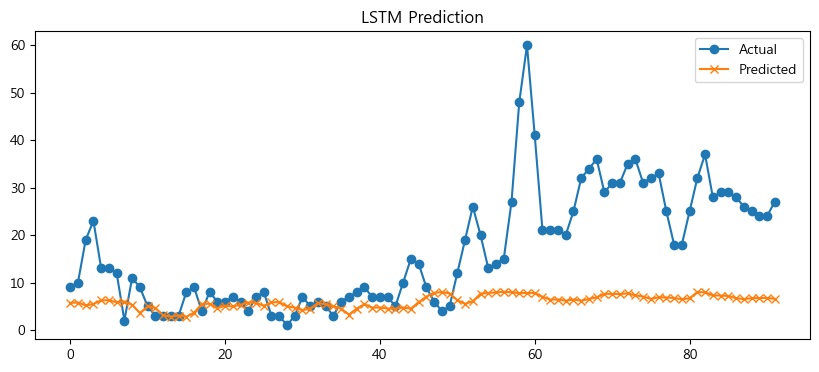

In [244]:
plt.figure(figsize=(10,4))
plt.plot(y_true, label='Actual', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')
plt.legend()
plt.title('LSTM Prediction')
plt.show()


In [245]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# 예시: df['Cases'] (타겟), df[['SO2', 'CO', ...]] (독립변수들)이 있다고 가정
# 0) numpy array로 변환
y_arr = df['Cases'].values.reshape(-1, 1)
X_arr = df[['SO2','CO','O3','NO2','PM10','PM25','평균기온(℃)','평균습도(%rh)']].values

# 1) 예시) MinMaxScaler 사용
scaler_X = MinMaxScaler(feature_range=(0,1))
X_scaled = scaler_X.fit_transform(X_arr)

scaler_y = MinMaxScaler(feature_range=(0,1))
y_scaled = scaler_y.fit_transform(y_arr)

# (참고) StandardScaler를 쓰려면
#scaler_X = StandardScaler()
#X_scaled = scaler_X.fit_transform(X_arr)
#... etc.


In [246]:
def create_sequence_features(data_array, target_array, window_size=7):
    Xs, ys = [], []
    for i in range(len(data_array) - window_size):
        Xs.append(data_array[i : i + window_size])
        ys.append(target_array[i + window_size])
    return np.array(Xs), np.array(ys)

window_size = 7
X_seq, y_seq = create_sequence_features(X_scaled, y_scaled, window_size=window_size)

print(X_seq.shape, y_seq.shape)  # (N-7, 7, num_features), (N-7, 1)


(679, 7, 8) (679, 1)


In [247]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 전체 시퀀스 데이터를 train/val로 분할(임의 80:20)
X_train, X_val, y_train, y_val = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

def build_lstm_model(units, dropout, lr):
    model = keras.Sequential([
        keras.layers.LSTM(units, activation='tanh', return_sequences=False, 
                          input_shape=(X_train.shape[1], X_train.shape[2])),
        keras.layers.Dropout(dropout),
        keras.layers.Dense(1) 
    ])
    optimizer = keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mse')
    return model

# 하이퍼파라미터 후보
param_units = [32, 64]        # 예시
param_dropout = [0.0, 0.2]    # 예시
param_lr = [1e-3, 1e-4]       # 예시
param_batch_size = [16, 32]   # 예시

best_val_rmse = float('inf')
best_config = None
best_model = None

for units in param_units:
    for dropout in param_dropout:
        for lr in param_lr:
            for bs in param_batch_size:
                
                print(f"[Try] units={units}, dropout={dropout}, lr={lr}, batch_size={bs}")
                
                model = build_lstm_model(units=units, dropout=dropout, lr=lr)
                
                # 학습(epochs 개수도 적당히)
                history = model.fit(
                    X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=10,
                    batch_size=bs,
                    verbose=0  # 학습로그 생략
                )
                
                # 검증 결과
                y_val_pred = model.predict(X_val).flatten()
                y_val_true = y_val.flatten()
                val_rmse = mean_squared_error(y_val_true, y_val_pred, squared=False)
                
                print(f"  val RMSE = {val_rmse:.4f}\n")
                
                # 최적치 갱신
                if val_rmse < best_val_rmse:
                    best_val_rmse = val_rmse
                    best_config = (units, dropout, lr, bs)
                    best_model = model

print("---- Best Hyperparams ----")
print("units=%d, dropout=%.2f, lr=%f, batch_size=%d" % best_config)
print("val RMSE=%.4f" % best_val_rmse)


[Try] units=32, dropout=0.0, lr=0.001, batch_size=16


C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
  val RMSE = 0.0674

[Try] units=32, dropout=0.0, lr=0.001, batch_size=32


C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
  val RMSE = 0.0692

[Try] units=32, dropout=0.0, lr=0.0001, batch_size=16


C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
  val RMSE = 0.0956

[Try] units=32, dropout=0.0, lr=0.0001, batch_size=32


C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
  val RMSE = 0.0658

[Try] units=32, dropout=0.2, lr=0.001, batch_size=16


C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
  val RMSE = 0.0691

[Try] units=32, dropout=0.2, lr=0.001, batch_size=32


C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
  val RMSE = 0.0783

[Try] units=32, dropout=0.2, lr=0.0001, batch_size=16


C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
  val RMSE = 0.0620

[Try] units=32, dropout=0.2, lr=0.0001, batch_size=32


C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
  val RMSE = 0.0650

[Try] units=64, dropout=0.0, lr=0.001, batch_size=16


C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
  val RMSE = 0.0675

[Try] units=64, dropout=0.0, lr=0.001, batch_size=32


C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
  val RMSE = 0.0654

[Try] units=64, dropout=0.0, lr=0.0001, batch_size=16


C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
  val RMSE = 0.0678

[Try] units=64, dropout=0.0, lr=0.0001, batch_size=32


C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
  val RMSE = 0.0703

[Try] units=64, dropout=0.2, lr=0.001, batch_size=16


C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
  val RMSE = 0.0707

[Try] units=64, dropout=0.2, lr=0.001, batch_size=32


C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
  val RMSE = 0.0680

[Try] units=64, dropout=0.2, lr=0.0001, batch_size=16


C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
  val RMSE = 0.0838

[Try] units=64, dropout=0.2, lr=0.0001, batch_size=32


C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
  val RMSE = 0.0794

---- Best Hyperparams ----
units=32, dropout=0.20, lr=0.000100, batch_size=16
val RMSE=0.0620


C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
